In [1]:
#defining map class
import matplotlib.pyplot as plt

class map:
    def __init__(self, sx, sy, gx, gy, ox, oy):
        self.sx = sx
        self.sy = sy
        self.gx = gx
        self.gy = gy
        self.ox = ox
        self.oy = oy
    
    #Visualizing map by matplotlib
    def plot_map(self):
        plt.plot(self.ox, self.oy, ":k")  # black dot dash line for obstacles
        plt.plot(self.sx, self.sy, "og")  # green O for start node
        plt.plot(self.gx, self.gy, "xb")  # blue X for target node
        plt.grid(True)
        plt.axis('equal')  # keeping the horizontal and vertical scales of the grid consistent


In [2]:
#defining a function to read map
def read_map(filename):
#     sx, sy = 0, 0 #start location
#     gx, gy = 0, 0 #target location
    ox, oy = [], [] # obstacle location

    with open(filename) as file:
        i = 0
        while line := file.readline():
            for j, char in enumerate(line):
                if char == 'W':
                    ox.append(j)
                    oy.append(i)
                else:
                    if char == 'S':
                        sx = j 
                        sy = i
                    elif char == 'T':
                        gx = j
                        gy = i
                    else:
                        continue
            i += 1
    
    return map(sx, sy, gx, gy, ox, oy)

In [4]:
amap = read_map("data_1.txt")

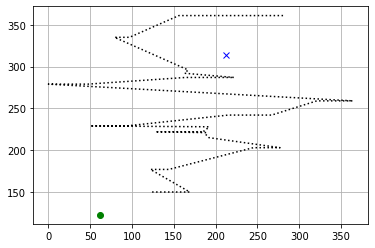

In [5]:
amap.plot_map()

In [6]:
import math
import numpy as np
from math import factorial

In [10]:
class AStarPlanner:

    def __init__(self, ox, oy, reso, rr):

        self.reso = reso   # grid resolution [m]
        self.rr = rr       # robot radius [m]
        self.calc_obstacle_map(ox, oy)
        self.motion = self.get_motion_model()



    # 创建一个节点类，节点的信息包括：xy坐标，cost代价,parent_index
    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x
            self.y = y
            self.cost = cost  # g(n)
            self.parent_index = parent_index

        def __str__(self):     # 返回字符串类型
            return str(self.x) + "," + str(self.y) + "," + str(
                self.cost) + "," + str(self.parent_index)
 

    # 经过这个函数进行处理，传入sx,sy,gx,gy, 返回pathx,pathy(最终的路径)
    def planning(self, sx, sy, gx, gy):
        """
        1、sx = nstart  sy = ngoal
        2、open_set  closed_set
        3、open_set = nstart 
        4、将open表中代价最小的子节点=当前节点，并在plot上动态显示，按esc退出
        5、如果当前节点等于ngoal，提示找到目标点
        6、删除open表中的内容，添加到closed表中
        7、基于运动模型定义搜索方式
        8、pathx,pathy = 最终路径(传入ngoal,closed_set)，返回pathx,pathy
        """
        # 1、sx = nstart  sy = ngoal  初始化nstart、ngoal坐标作为一个节点，传入节点全部信息
        nstart = self.Node(self.calc_xyindex(sx, self.minx),  # position min_pos
                           self.calc_xyindex(sy, self.miny),
                           0.0,
                           -1)
        ngoal = self.Node(self.calc_xyindex(gx, self.minx),
                           self.calc_xyindex(gy, self.miny),
                           0.0,
                           -1)

        # 2、open表、closed表设定为字典
        # 3、起点加入open表 
        open_set, closed_set = dict(), dict()   
        open_set[self.calc_grid_index(nstart)] = nstart  

        while 1:
            if len(open_set) == 0:
                print("Open set is empty...")
                break
            
        # 4、将open表中代价最小的子节点 = 当前节点，并在plot上动态显示，按esc退出  
            # f(n)=g(n)+h(n)  实际代价+预估代价  
            # 第几个子节点 child_node_id
            c_id = min(
                open_set, 
                key=lambda o: open_set[o].cost + self.calc_heuristic(ngoal, open_set[o]))
            current = open_set[c_id]   # open表中当前节点 = 当前节点

            # 将当前节点显示出来
            if show_animation:
                plt.plot(self.calc_grid_position(current.x, self.minx),
                         self.calc_grid_position(current.y, self.miny),
                         "xc")   # 青色x 搜索点
                # 按esc退出
                plt.gcf().canvas.mpl_connect('key_release_event',
                                              lambda event: [exit(0) if event.key == 'escape' else None]
                                            )
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)

            if current.x == ngoal.x and current.y == ngoal.y:
                print("Find goal!")
                ngoal.parent_index = current.parent_index
                ngoal.cost = current.cost
                break

            # 删除open表中的节点,并把它添加到closed表
            del open_set[c_id]
            closed_set[c_id] = current

            # 基于motion model做栅格扩展，也就是搜索方式，可进行改进，如使用JPS策略
            for i, _ in enumerate(self.motion):
                node = self.Node(current.x + self.motion[i][0],    # 当前x+motion列表中第0个元素dx
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2],c_id)
                n_id = self.calc_grid_index(node)   # 返回该节点位置index

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node
                else:
                    if open_set[n_id].cost > node.cost:
                        open_set[n_id] = node    # 搜索的节点代价更小，替代open表中的节点

        pathx, pathy = self.calc_final_path(ngoal, closed_set) 
        
        return pathx, pathy

    
    def calc_final_path(self, ngoal, closedset):    # 传入目标点和close表，经过函数处理得到最终所有的xy列表
        pathx, pathy = [self.calc_grid_position(ngoal.x, self.minx)], [
                        self.calc_grid_position(ngoal.y, self.miny)]
        parent_index = ngoal.parent_index
        while parent_index != -1:
            n = closedset[parent_index]
            pathx.append(self.calc_grid_position(n.x, self.minx))
            pathy.append(self.calc_grid_position(n.y, self.miny))
            parent_index = n.parent_index

        return pathx, pathy


                

    @staticmethod  # 静态方法，calc_heuristic函数不用传入self，经常改进启发函数，所以为了提高阅读性
    def calc_heuristic(n1, n2):  # n1传入ngoal，n2传入open表要计算的那个点

        """
        改进点1：启发函数距离公式 曼哈顿距离、欧式距离、对角线距离   
        """
        # d = np.abs(n1.x - n2.x) + np.abs(n1.y - n2.y)     #  Manhattan

        # dx = np.abs(n1.x - n2.x)                          #  Diagnol distance 
        # dy = np.abs(n1.y - n2.y)
        # min_xy = min(dx,dy)
        # d = dx + dy + (math.sqrt(2) - 2) * min_xy   

        d = math.hypot(n1.x - n2.x, n1.y - n2.y)          #  Euclidean

        print(d)


        """
        改进点2：f(n)=g(n)+h(n)*w(n)
        动态加权：在放弃搜索最优路径的情况下，使用动态加权来缩短A*搜索的时间
        其原则为，在搜索开始时，快速到达目的地所在区域更重要；在搜索结束时，得到到达目标的最佳路径更重要
        当h较大时，权重系数w也应该较大，此时A*算法会尽快向终点扩展，搜索速度很快但会错过最优路径；当h较小时，w也应该较小，此时A*算法会倾向于搜索最优路径而减慢搜索速度。   
        如何找到最优选择，需要根据地图情况，多次调节参数
        """      
        if d > 18:
            w = 3.0
        else: w = 1.0

        h = w * d


        #return d
        return h    # 传入2个点，返回h值



    # 传入地图中最小处障碍物的坐标和index，得到全局范围下某个坐标
    def calc_grid_position(self, index, minpos):   
        pos = index * self.reso + minpos
        return pos


    # 计算xy坐标函数，传入position,min_pos，返回x/y坐标   
    def calc_xyindex(self, position, min_pos):
        return round((position - min_pos) / self.reso)  # (当前节点-最小处的坐标)/分辨率=pos_index

    # 计算栅格地图index，传入某个节点，返回当前节点的栅格index
    def calc_grid_index(self, node):
        return (node.y - self.miny) * self.xwidth + (node.x - self.minx)

    # 验证是否为安全节点函数
    def verify_node(self, node):
        posx = self.calc_grid_position(node.x, self.minx)
        posy = self.calc_grid_position(node.y, self.miny)

        if posx < self.minx:
            return False
        elif posy < self.miny:
            return False
        elif posx >= self.maxx:
            return False
        elif posy >= self.maxy:
            return False

        if self.obmap[int(node.x)][int(node.y)]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy):
        self.minx = round(min(ox))    # 地图中的临界值
        self.miny = round(min(oy))  
        self.maxx = round(max(ox))  
        self.maxy = round(max(oy))  
        print("minx:", self.minx)
        print("miny:", self.miny)
        print("maxx:", self.maxx)
        print("maxy:", self.maxy)

        self.xwidth = round((self.maxx - self.minx) / self.reso)
        self.ywidth = round((self.maxy - self.miny) / self.reso)
        print("xwidth:", self.xwidth)
        print("ywidth:", self.ywidth)

        self.obmap = [[False for i in range(int(self.ywidth))]
                       for i in range(int(self.xwidth))]
        for ix in range(int(self.xwidth)):
            x = self.calc_grid_position(ix, self.minx)
            for iy in range(int(self.ywidth)):
                y = self.calc_grid_position(iy, self.miny)
                for iox, ioy in zip(ox, oy):  #将ox,oy打包成元组，返回列表，并遍历
                    d = math.hypot(iox - x, ioy - y)  
                    if d <= self.rr:          #代价小于车辆半径，可正常通过，不会穿越障碍物
                        self.obmap[ix][iy] = True
                        break



    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        # 搜索的8个邻域，可改进为：5个、16个、32个、48个等(参考论文)
        motion = [
                    [1, 0, 1],
                    [0, 1, 1],
                    [-1, 0, 1],
                    [0, -1, 1],
                    [1, 1, math.sqrt(2)],
                    [1, -1, math.sqrt(2)],
                    [-1, 1, math.sqrt(2)],
                    [-1, -1, math.sqrt(2)]

                    # [2,1,math.sqrt(5)],
                    # [1,2,math.sqrt(5)],
                    # [-2,1,math.sqrt(5)],
                    # [-1,2,math.sqrt(5)],
                    # [-2,-1,math.sqrt(5)],
                    # [-1,-2,math.sqrt(5)],
                    # [1,-2,math.sqrt(5)],
                    # [2,-1,math.sqrt(5)]

                #   [3,1,math.sqrt(10)],
                #   [1,3,math.sqrt(10)],
                #   [-3,1,math.sqrt(10)],
                #   [-1,3,math.sqrt(10)],
                #   [-3,-1,math.sqrt(10)],
                #   [-1,-3,math.sqrt(10)],
                #   [1,-3,math.sqrt(10)],
                #   [3,-1,math.sqrt(10)]

                #   [3,2,math.sqrt(13)],
                #   [2,3,math.sqrt(13)],
                #   [-3,2,math.sqrt(13)],
                #   [-2,3,math.sqrt(13)],
                #   [-3,-2,math.sqrt(13)],
                #   [-2,-3,math.sqrt(13)],
                #   [2,-3,math.sqrt(13)],
                #   [3,-2,math.sqrt(13)]


                  ]
        
        return motion


In [8]:
def main():
    print('  Start!')
    plt.title("improved astar")
    amap = read_map("C:/Users/19807/Desktop/CV FINAL/data_1.txt")
    if show_animation:
        amap.plot_map()

    sx = amap.sx
    sy = amap.sy
    gx = amap.gy
    gy = amap.gy
    ox = amap.ox
    oy = amap.oy
    grid_size = 2.0
    robot_radius = 1.0



    a_star = AStarPlanner(ox, oy, grid_size ,robot_radius)  # grid_size=reso 初始化中传入的参数
    pathx, pathy = a_star.planning(sx, sy, gx, gy)  # 开始与结束的坐标传入函数进行处理后，得到pathx,pathy：最终规划出的路径坐标

    # # 贝塞尔曲线的控制点，为了方便更改，可根据出图效果调整
    # points = np.array([[pathx[0], pathy[0]], [pathx[1], pathy[1]], [pathx[2], pathy[2]],
    #                     [pathx[3], pathy[3]],[pathx[4], pathy[4]],[pathx[5], pathy[5]],
    #                     [pathx[6], pathy[6]],[pathx[7], pathy[7]],[pathx[8], pathy[8]],
    #                     [pathx[9], pathy[9]],[pathx[10], pathy[10]],[pathx[11], pathy[11]],
    #                     [pathx[12], pathy[12]],[pathx[13], pathy[13]],[pathx[14], pathy[14]],
    #                     [pathx[15], pathy[15]]])
    # points1 = np.array([[pathx[15], pathy[15]], [pathx[16], pathy[16]],[pathx[17], pathy[17]]])
    # points2 = np.array([[pathx[17], pathy[17]],[pathx[18], pathy[18]], [pathx[19], pathy[19]], [pathx[20], pathy[20]],
    #                     [pathx[21], pathy[21]],[pathx[22], pathy[22]],[pathx[23], pathy[23]],
    #                     [pathx[24], pathy[24]],[pathx[25], pathy[25]],[pathx[26], pathy[26]],
    #                     [pathx[27], pathy[27]]])
    # points3 = np.array([[pathx[27], pathy[27]],[pathx[28], pathy[28]],[pathx[29], pathy[29]]])
    # points4 = np.array([[pathx[29], pathy[29]],[pathx[30], pathy[30]], [pathx[31], pathy[31]], [pathx[32], pathy[32]],
    #                     [pathx[33], pathy[33]],[pathx[34], pathy[34]],[pathx[35], pathy[35]],
    #                     [pathx[36], pathy[36]],[pathx[37], pathy[37]],[pathx[38], pathy[38]],
    #                     [pathx[39], pathy[39]],[pathx[40], pathy[40]],[pathx[41], pathy[41]],
    #                     [pathx[42], pathy[42]],[pathx[43], pathy[43]],[pathx[44], pathy[44]],
    #                     [pathx[45], pathy[45]],[pathx[46], pathy[46]],[pathx[47], pathy[47]],
    #                     [pathx[48], pathy[48]],[pathx[49], pathy[49]],[pathx[50], pathy[50]],
    #                     [pathx[51], pathy[51]],[pathx[52], pathy[52]]])
    #
    # bx, by = evaluate_bezier(points, 50)
    # bx1, by1 = evaluate_bezier(points1, 50)
    # bx2, by2 = evaluate_bezier(points2, 50)
    # bx3, by3 = evaluate_bezier(points3, 50)
    # bx4, by4 = evaluate_bezier(points4, 50)
    #
    #
    #
    # if show_animation:
    #     plt.plot(pathx, pathy, "-r")  # 红色直线 最终路径
    #     plt.plot(bx, by, 'b-')      # 蓝色直线 贝塞尔曲线
    #     plt.plot(bx1, by1, 'b-')
    #     plt.plot(bx2, by2, 'b-')
    #     plt.plot(bx3, by3, 'b-')
    #     plt.plot(bx4, by4, 'b-')
    #
    #     plt.show()
    #     plt.pause(0.001)   # 动态显示


  Start!
minx: 0
miny: 150
maxx: 364
maxy: 361
xwidth: 182
ywidth: 106
158.40454538932903


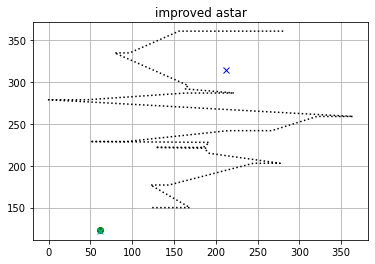

Open set is empty...


In [19]:
show_animation = True

if __name__ == '__main__':
    main()